In [8]:
from pathlib import Path
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from affine import Affine
from tqdm.notebook import tqdm

# reading in geotiff file as numpy array
def read_tif(file: Path):

    if not file.exists():
        raise FileNotFoundError(f'File {file} not found')

    with rasterio.open(file) as dataset:
        arr = dataset.read()  # (bands X height X width)
        transform = dataset.transform
        crs = dataset.crs

    return arr.transpose((1, 2, 0)), transform, crs


# writing an array to a geo tiff file
def write_tif(file: Path, arr, transform, crs):

    if not file.parent.exists():
        file.parent.mkdir()

    if len(arr.shape) == 3:
        height, width, bands = arr.shape
    else:
        height, width = arr.shape
        bands = 1
        arr = arr[:, :, None]
    with rasterio.open(
            file,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=bands,
            dtype=arr.dtype,
            crs=crs,
            transform=transform,
    ) as dst:
        for i in range(bands):
            dst.write(arr[:, :, i], i + 1)

In [14]:
# reading in psi (percentage impervious surface), reasterized census data and osm transportation features

data_path = Path('C:/Users/shafner/slum_extent_mapping/data/population_disaggregation')

year = 2020
pop_index = 1 if year == 2016 else 2
    
pis_file = data_path / f'psi_{year}.tif'
psi, geotransform, crs = read_tif(pis_file)
psi = psi[:, :, 0]
osm_file = data_path / 'osm_features.tif'
non_builtup, _, _ = read_tif(osm_file)
non_builtup = non_builtup[:, :, 0]
cell_pop_file = data_path / 'census_data_kigali.tif'
cell_pop_data, _, _ = read_tif(cell_pop_file)
cell_ids = cell_pop_data[:, :, 0]
cell_pop = cell_pop_data[:, :, pop_index]

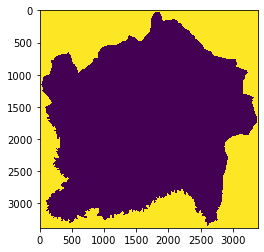

In [15]:
beyond_roi = cell_pop == 0
plt.imshow(beyond_roi)

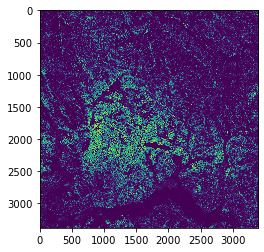

In [16]:
# removing non built-up with osm transportation features

builtup_density = psi
builtup_density[non_builtup == 1] = 0

# no population is assigned to pixels with less than threshold builtup
# min_builtup_threshold = 33
# builtup_density[builtup_density < min_builtup_threshold] = 0

plt.imshow(builtup_density)

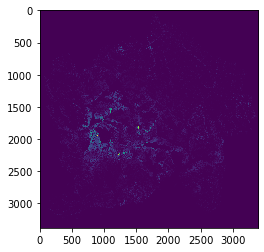

In [17]:
# disaggregation census data based on builtup data

pop_disaggregated = np.zeros(cell_ids.shape)

ids = np.unique(cell_ids)
for cell_id in tqdm(ids):
    if cell_id != 0:
        
        cell_bool = cell_ids == cell_id
        
        size = np.sum(cell_bool)
        pop = np.mean(cell_pop[cell_bool])
        builtup = np.sum(builtup_density[cell_bool])
        
        person_per_builtup = pop / builtup

        pop_disaggregated_cell = builtup_density * cell_bool * person_per_builtup
        pop_disaggregated = pop_disaggregated + pop_disaggregated_cell
   
        builtup_percentage = builtup / size
        # print(f'{cell_id}: {builtup_percentage:.2f} {pop:.0f}')
plt.imshow(pop_disaggregated)

In [18]:
# saving output
pop_disaggregated[beyond_roi] = np.NaN
output_file = data_path / f'population_disaggregated_{year}.tif'
write_tif(output_file, pop_disaggregated, geotransform, crs)

In [19]:
def aggregate(input_file: Path, cell_size: int, output_name: str, band: int = None, normalize: bool = False,
             mask: np.ndarray = None):

    # reading in data
    data, geotransform, crs = read_tif(input_file)
    data = data.astype(np.float32)
    
    if mask is not None:
        data[mask] = np.NaN

    # aggregating to cell_size
    m, n, _ = data.shape
    if band is not None:
        data = data[:, :, band]
        data = data[:, :, None]
    m_agg, n_agg = m // cell_size, n // cell_size
    data_agg = np.zeros((m_agg, n_agg))

    for i in range(0, m, cell_size):
        for j in range(0, n, cell_size):

            # sum population in grid cell
            cell_data = data[i:i+cell_size, j:j+cell_size]
            if not np.isnan(np.min(cell_data)):
                cell_value = np.sum(cell_data)
                if normalize:
                    cell_value = cell_value / cell_data.size
            else:
                cell_value = np.NaN
            
            # assign it to new grid if within bounds
            i_agg, j_agg = i // cell_size, j // cell_size
            if i_agg < m_agg and j_agg < n_agg:
                data_agg[i_agg, j_agg] = cell_value

    # new geotransform    
    x_spacing, _, x_origin, _, y_spacing, y_origin, _, _ , _ = geotransform
    x_spacing_agg = x_spacing * cell_size
    y_spacing_agg = y_spacing * cell_size
    geotransform_agg = (x_origin, x_spacing_agg, 0.0, y_origin, 0.0, y_spacing_agg)
    geotransform_agg = Affine.from_gdal(*geotransform_agg)     

    # saving to file
    output_file = input_file.parent / f'{output_name}.tif'
    write_tif(output_file, data_agg, geotransform_agg, crs)

In [26]:
# aggregating population data

year = 2016
cell_size = 25


pop_file = data_path / f'population_disaggregated_{year}.tif'
output_name = f'population_aggregated_cell{cell_size*10:.0f}_{year}'
aggregate(pop_file, cell_size, output_name)

In [29]:
# aggregating psi data
year = 2016
cell_size = 100


psi_file = data_path / f'psi_{year}.tif'
output_name = f'psi_aggregated_cell{cell_size*10:.0f}_{year}'
aggregate(psi_file, cell_size, output_name, band=0, normalize=True, mask=beyond_roi)            
  


In [31]:
t1 = 2016
t2 = 2020
dt = t2 - t1

cell_size = 100

# reading in psi data
psi_t1_file = data_path / f'psi_aggregated_cell{cell_size*10:.0f}_{t1}.tif'
psi_t1, geotransform, crs = read_tif(psi_t1_file)
psi_t2_file = data_path / f'psi_aggregated_cell{cell_size*10:.0f}_{t2}.tif'
psi_t2, _, _ = read_tif(psi_t2_file)


# computing land consumption rate
lcr = np.log(psi_t2 / psi_t1) / dt

# reading in population data
pop_t1_file = data_path / f'population_aggregated_cell{cell_size*10:.0f}_{t1}.tif'
pop_t1, _, _ = read_tif(pop_t1_file)
pop_t2_file = data_path / f'population_aggregated_cell{cell_size*10:.0f}_{t2}.tif'
pop_t2, _, _ = read_tif(pop_t2_file)

# computing population growth rate
pgr = np.log(pop_t2 / pop_t1) / dt

lcrpgr = lcr / pgr


# saving stuff
lcr_output_file = data_path / f'lcr_cell{cell_size*10:.0f}.tif'
write_tif(lcr_output_file, lcr, geotransform, crs)

pgr_output_file = data_path / f'pgr_cell{cell_size*10:.0f}.tif'
write_tif(pgr_output_file, pgr, geotransform, crs)

lcpgr_output_file = data_path / f'lcpgr_cell{cell_size*10:.0f}.tif'
write_tif(lcpgr_output_file, pgr, geotransform, crs)


In [47]:
# standard deviation shit
data_cube = None
start_year = 2016
end_year = 2020
for i, year in enumerate(range(start_year, end_year + 1)):
    pis_file = data_path / f'psi_{year}.tif'
    arr, geotransform, crs = read_tif(pis_file)
    if data_cube is None:
        m, n, _ = arr.shape
        data_cube = np.empty((m, n, end_year - start_year + 1), dtype=np.int)
    
    data_cube[:, :, i] = arr[:, :, 0]

std = np.std(data_cube, axis=2)
std_file = data_path / 'psi_std.tif'
write_tif(std_file, std, geotransform, crs)

# aggregating population data
cell_size = 100

output_name = f'psi_std_cell{cell_size*10:.0f}'
aggregate(std_file, cell_size, output_name, normalize=True, mask=beyond_roi)